# Logistic Regression Predicitons

Notebook to explore logistic regression applied to football match prediction

## 1. Imports

In [1]:
from IPython.display import display, Latex, Markdown

import datetime as dt
from importlib import reload
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3
import warnings

from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm

from epl.query import create_and_query
from epl.match_utils import full_table_calculator, league_table_asof, result_calculator, table_calculator
from epl.feature_utils import add_game_week, add_league_pos, add_prev_season_pos, add_result_streak, add_avg_cols
from epl.model_utils import gen_sm_logit_preds, print_conf_mat, print_logit_params, sm_logit_output_explanation

pd.options.display.max_columns = None
pd.options.display.max_rows = 100
warnings.filterwarnings('ignore')

In [2]:
df_raw = create_and_query('matches', cols=['Div', 'Season', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HS', 'AS', 'HST', 'AST', 'B365H', 'B365D', 'B365A'])
df_raw['Date'] = pd.to_datetime(df_raw['Date'])
df_raw = df_raw.sort_values('Date', ascending=True)
df_raw.tail()

Running query: SELECT Div, Season, Date, HomeTeam, AwayTeam, FTHG, FTAG, FTR, HS, [AS], HST, AST, B365H, B365D, B365A FROM matches 


,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,HST,AST,B365H,B365D,B365A
200,E3,2020/2021,2020-10-13,Cheltenham,Grimsby,1.0,3.0,A,20.0,9.0,5.0,3.0,1.72,3.90,4.60
243,EC,2020/2021,2020-10-13,Woking,Dag and Red,2.0,0.0,H,NaN,NaN,NaN,NaN,3.60,3.50,2.00
242,EC,2020/2021,2020-10-13,Wealdstone,Stockport,2.0,5.0,A,NaN,NaN,NaN,NaN,3.75,3.75,1.90
240,EC,2020/2021,2020-10-13,Sutton,Notts County,0.0,1.0,A,NaN,NaN,NaN,NaN,3.00,3.30,2.37
237,EC,2020/2021,2020-10-13,Halifax,Yeovil,1.0,1.0,D,NaN,NaN,NaN,NaN,2.75,3.40,2.45


Will limit to only studying the top leagues

In [3]:
top_divs = ['E0', 'D1', 'B1', 'I1', 'F1', 'G1', 'N1', 'SC0', 'T1']
df_raw = df_raw[df_raw.Div.isin(top_divs)].dropna()

## 2. Benchmark

Before we try to make some predictions, we can have a look at how well the bookies do at predicting match outcomes

This can then serve as a benchmark if they perform well

It can also help us identify games that are 'difficult' to predict or general biases in our predictions

### 2a. The Bookies Markup

Bookies make money by taking spread - if they generate equal __payouts__ (not betted money) on either side they capture risk-free the whole spread

In [4]:
df_bookies = df_raw.copy()
df_bookies['Total_Odds'] = (1 / df_bookies.B365H) + (1 / df_bookies.B365D) + (1 / df_bookies.B365A)

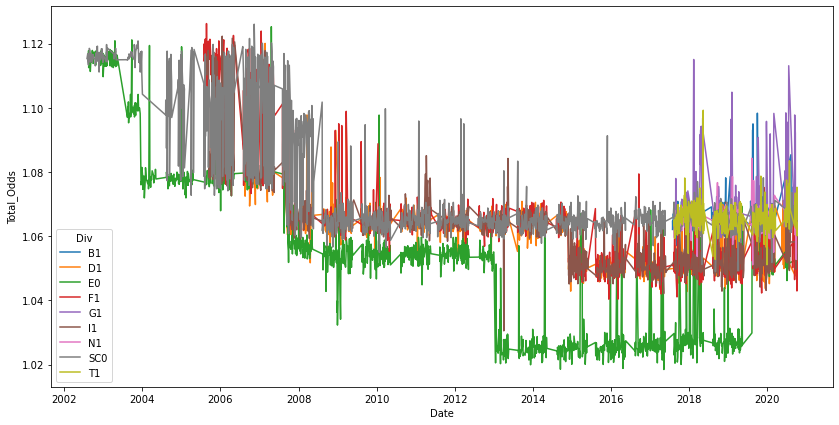

In [5]:
fig, ax = plt.subplots(figsize=(14,7))
sns.lineplot(data=df_bookies[['Div', 'Date', 'Total_Odds']].groupby(['Div', 'Date']).mean().reset_index(), x='Date', y='Total_Odds', hue='Div', ax=ax);

As we can see this spread has been decreasing over the last 20 years as the industry has become more competitive, more data is available and the rise of data science has helped to improve their prediciton accuracy

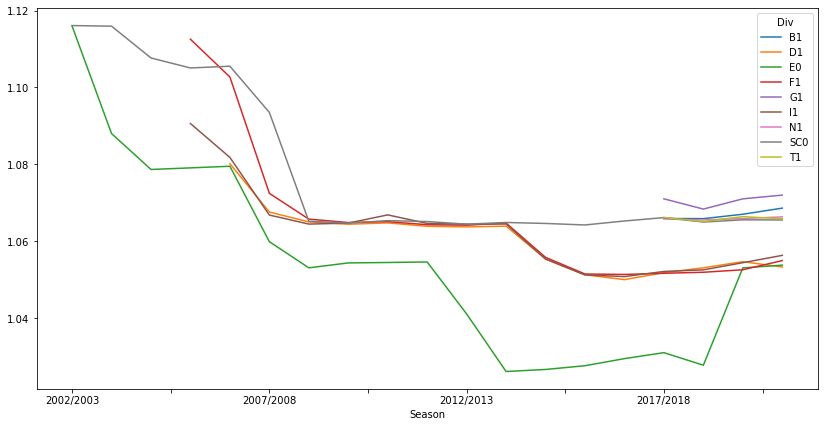

In [6]:
pd.pivot_table(data=df_bookies[['Div', 'Season', 'Total_Odds']].groupby(['Div', 'Season']).mean().reset_index(), index='Season', columns='Div', values='Total_Odds').plot(figsize=(14,7));

### 2b. Bookies Estimated Probabilities

1 over the odds gives us the estimated bookie probabilities of an outcome

We can compute these, bucket them and display 'actual probabilities' vs 'predicted probabilities' to see how well the bookies predict outcomes

In [7]:
df_bookies['ProbabHome'] = 1 / df_bookies['B365H']
df_bookies['ProbabAway'] = 1 / df_bookies['B365A']

In [8]:
num_bins = 50
bins = [x/num_bins for x in range(1, num_bins + 1)]

In [9]:
df_bookies['ProbabHomeBin'] = pd.cut(df_bookies['ProbabHome'], bins, labels=[round(x + (1/num_bins/2), 4) for x in bins[:-1]])
df_bookies['ProbabAwayBin'] = pd.cut(df_bookies['ProbabAway'], bins, labels=[round(x + (1/num_bins/2), 4) for x in bins[:-1]])
df_bookies

,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,HST,AST,B365H,B365D,B365A,Total_Odds,ProbabHome,ProbabAway,ProbabHomeBin,ProbabAwayBin
74260,SC0,2002/2003,2002-08-03,Kilmarnock,Rangers,1.0,1.0,D,6.0,16.0,4.0,9.0,7.500,3.75,1.400,1.114286,0.133333,0.714286,0.13,0.71
74262,SC0,2002/2003,2002-08-03,Partick,Dundee United,0.0,0.0,D,9.0,9.0,2.0,3.0,2.250,3.25,2.750,1.115773,0.444444,0.363636,0.45,0.37
74261,SC0,2002/2003,2002-08-03,Livingston,Motherwell,3.0,2.0,H,10.0,7.0,5.0,5.0,1.571,3.60,5.000,1.114315,0.636537,0.200000,0.63,0.19
74259,SC0,2002/2003,2002-08-03,Hibernian,Aberdeen,1.0,2.0,A,12.0,8.0,4.0,2.0,2.375,3.20,2.625,1.114505,0.421053,0.380952,0.43,0.39
74257,SC0,2002/2003,2002-08-03,Celtic,Dunfermline,2.0,1.0,H,19.0,4.0,8.0,2.0,1.143,6.00,13.000,1.118480,0.874891,0.076923,0.87,0.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182402,G1,2020/2021,2020-10-04,Panathinaikos,Aris,0.0,1.0,A,8.0,6.0,2.0,3.0,1.950,3.30,4.000,1.065851,0.512821,0.250000,0.51,0.25
152894,N1,2020/2021,2020-10-04,Groningen,Ajax,1.0,0.0,H,11.0,19.0,3.0,3.0,6.500,5.00,1.400,1.068132,0.153846,0.714286,0.15,0.71
61694,SC0,2020/2021,2020-10-04,St Johnstone,Celtic,0.0,2.0,A,7.0,19.0,0.0,3.0,10.000,6.00,1.250,1.066667,0.100000,0.800000,0.09,0.79
95502,I1,2020/2021,2020-10-04,Atalanta,Cagliari,5.0,2.0,H,19.0,7.0,14.0,3.0,1.250,6.50,10.000,1.053846,0.800000,0.100000,0.79,0.09


In [10]:
# separate into home and away win dfs
home_wins = df_bookies[df_bookies.FTR == 'H'][['FTR', 'ProbabHomeBin']].groupby(['ProbabHomeBin']).count()
all_games = df_bookies[['FTR', 'ProbabHomeBin']].groupby(['ProbabHomeBin']).count()
home_win_pc = (home_wins / all_games).reset_index()
home_win_pc = home_win_pc.astype(float)

away_wins = df_bookies[df_bookies.FTR == 'A'][['FTR', 'ProbabAwayBin']].groupby(['ProbabAwayBin']).count()
all_games = df_bookies[['FTR', 'ProbabAwayBin']].groupby(['ProbabAwayBin']).count()
away_win_pc = (away_wins / all_games).reset_index()
away_win_pc = away_win_pc.astype(float)

In [11]:
home_win_pc = home_win_pc.dropna()
home_win_pc.columns = ['BookiesProbab', 'RealisedHomeWins']
away_win_pc = away_win_pc.dropna()
away_win_pc.columns = ['BookiesProbab', 'RealisedAwayWins']

In [12]:
win_probab = pd.merge(left=home_win_pc, right=away_win_pc, how='outer', on='BookiesProbab')
win_probab = pd.melt(win_probab, id_vars=['BookiesProbab'], value_vars=['RealisedHomeWins', 'RealisedAwayWins'], var_name='HomeAway', value_name='Probab') 
win_probab['HomeAway'] = np.where(win_probab['HomeAway'] == 'RealisedHomeWins', 'Home', 'Away')

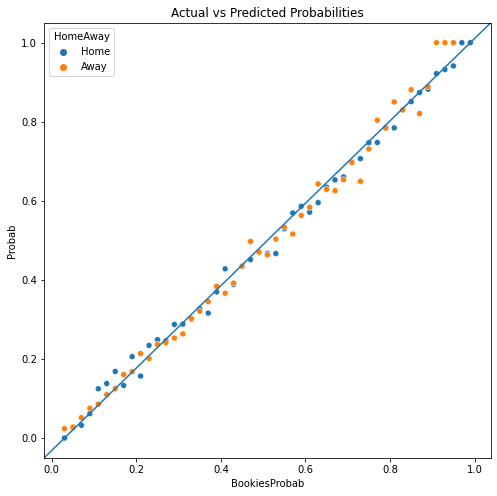

In [13]:
fig, ax = plt.subplots(figsize=(8,8))
sns.scatterplot(data=win_probab, x='BookiesProbab', y='Probab', hue='HomeAway', ax=ax);
ax.plot([0, 1], [0, 1], transform=ax.transAxes);
ax.set_title('Actual vs Predicted Probabilities');

As we can see, the bookies are very good at their job

As such, their estimated probabilities can serve as a good benchmark for our models and differences can be identified and investigated - potentially to discover newly important factors

## 3. Build Factors

Add on a few key factors that are potentially helpful to predict - we can investigate this post prediction

In [14]:
df = df_raw[df_raw.Div == 'E0']

In [15]:
cols = ['GF', 'GA', 'SF', 'SA', 'STF', 'STA', 'PPG']
streaks = [3,5,10,20]

In [18]:
for s in  streaks:
    print('Calculating vars for streak: {}'.format(s))
    df = add_avg_cols(df, cols, s)

Calculating vars for streak: 3
Calculating vars for streak: 5
Calculating vars for streak: 10
Calculating vars for streak: 20


In [16]:
# add features
df = add_game_week(df)
df, tables_df = add_league_pos(df)
df = add_prev_season_pos(df, tables_df)

Adding game week for div: E0
Computing league table for div: E0, season: 2002/2003
Computing league table for div: E0, season: 2003/2004
Computing league table for div: E0, season: 2004/2005
Computing league table for div: E0, season: 2005/2006
Computing league table for div: E0, season: 2006/2007
Computing league table for div: E0, season: 2007/2008
Computing league table for div: E0, season: 2008/2009
Computing league table for div: E0, season: 2009/2010
Computing league table for div: E0, season: 2010/2011
Computing league table for div: E0, season: 2011/2012
Computing league table for div: E0, season: 2012/2013
Computing league table for div: E0, season: 2013/2014
Computing league table for div: E0, season: 2014/2015
Computing league table for div: E0, season: 2015/2016
Computing league table for div: E0, season: 2016/2017
Computing league table for div: E0, season: 2017/2018
Computing league table for div: E0, season: 2018/2019
Computing league table for div: E0, season: 2019/2020

In [135]:
feat_cols = ['Points', 'LeagPos', 'PrevLeagPos']
feat_cols = ['Avg'+i+'_'+str(j) for i in cols for j in streaks] + feat_cols
for c in feat_cols:
    df['H'+c+'Adv'] = df['H'+c] - df['A'+c]

In [136]:
df.tail()

,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,HST,AST,B365H,B365D,B365A,HGW,AGW,HPoints,HLeagPos,APoints,ALeagPos,HPrevLeagPos,APrevLeagPos,HAvgGF_3,AAvgGF_3,HAvgGA_3,AAvgGA_3,HAvgSF_3,AAvgSF_3,HAvgSA_3,AAvgSA_3,HAvgSTF_3,AAvgSTF_3,HAvgSTA_3,AAvgSTA_3,HAvgPPG_3,AAvgPPG_3,HAvgGF_5,AAvgGF_5,HAvgGA_5,AAvgGA_5,HAvgSF_5,AAvgSF_5,HAvgSA_5,AAvgSA_5,HAvgSTF_5,AAvgSTF_5,HAvgSTA_5,AAvgSTA_5,HAvgPPG_5,AAvgPPG_5,HAvgGF_10,AAvgGF_10,HAvgGA_10,AAvgGA_10,HAvgSF_10,AAvgSF_10,HAvgSA_10,AAvgSA_10,HAvgSTF_10,AAvgSTF_10,HAvgSTA_10,AAvgSTA_10,HAvgPPG_10,AAvgPPG_10,HAvgGF_20,AAvgGF_20,HAvgGA_20,AAvgGA_20,HAvgSF_20,AAvgSF_20,HAvgSA_20,AAvgSA_20,HAvgSTF_20,AAvgSTF_20,HAvgSTA_20,AAvgSTA_20,HAvgPPG_20,AAvgPPG_20,HAvgGF_3Adv,HAvgGF_5Adv,HAvgGF_10Adv,HAvgGF_20Adv,HAvgGA_3Adv,HAvgGA_5Adv,HAvgGA_10Adv,HAvgGA_20Adv,HAvgSF_3Adv,HAvgSF_5Adv,HAvgSF_10Adv,HAvgSF_20Adv,HAvgSA_3Adv,HAvgSA_5Adv,HAvgSA_10Adv,HAvgSA_20Adv,HAvgSTF_3Adv,HAvgSTF_5Adv,HAvgSTF_10Adv,HAvgSTF_20Adv,HAvgSTA_3Adv,HAvgSTA_5Adv,HAvgSTA_10Adv,HAvgSTA_20Adv,HAvgPPG_3Adv,HAvgPPG_5Adv,HAvgPPG_10Adv,HAvgPPG_20Adv,HPointsAdv,HLeagPosAdv,HPrevLeagPosAdv
6784,E0,2020/2021,2020-10-04,Man United,Tottenham,1.0,6.0,A,5.0,22.0,2.0,8.0,1.85,3.8,4.00,3.0,4.0,3.0,13.0,7.0,5.0,3.0,6.0,2.0,2.000000,1.666667,1.333333,9.000000,13.666667,15.333333,11.666667,3.333333,7.666667,4.333333,4.000000,2.0,1.333333,1.8,2.0,1.2,1.0,11.0,11.0,14.2,14.4,3.8,5.6,4.2,4.0,2.0,1.6,2.5,1.7,1.0,1.0,12.3,10.8,10.8,13.4,5.1,4.6,3.3,4.0,2.3,1.8,1.90,1.55,0.9,1.05,13.10,11.75,10.90,14.20,5.30,4.40,3.15,4.35,1.90,1.65,0.000000,-0.2,0.8,0.35,0.333333,0.2,0.0,-0.15,-4.666667,0.0,1.5,1.35,3.666667,-0.2,-2.6,-3.30,-4.333333,-1.8,0.5,0.9,0.333333,0.2,-0.7,-1.20,0.666667,0.4,0.5,0.25,-4.0,8.0,-3.0
6786,E0,2020/2021,2020-10-04,Southampton,West Brom,2.0,0.0,H,13.0,5.0,7.0,2.0,1.72,3.8,4.75,4.0,4.0,3.0,14.0,1.0,17.0,11.0,20.0,1.0,1.666667,2.000000,3.666667,9.333333,7.333333,8.000000,17.333333,4.333333,2.666667,3.666667,8.000000,1.0,0.333333,1.6,1.2,1.4,2.6,11.4,7.6,8.0,16.2,5.0,2.0,3.4,6.8,1.8,0.8,1.6,1.2,1.2,1.8,12.3,9.3,10.3,13.9,5.1,2.8,3.3,4.8,1.8,1.2,1.45,1.05,1.4,1.95,13.50,9.45,9.90,14.40,5.20,2.90,3.90,5.15,1.50,0.80,-0.666667,0.4,0.4,0.40,-1.666667,-1.2,-0.6,-0.55,2.000000,3.8,3.0,4.05,-9.333333,-8.2,-3.6,-4.50,1.666667,3.0,2.3,2.3,-4.333333,-3.4,-1.5,-1.25,0.666667,1.0,0.6,0.70,2.0,-3.0,-9.0
6782,E0,2020/2021,2020-10-04,Arsenal,Sheffield United,2.0,1.0,H,6.0,6.0,5.0,2.0,1.57,4.0,6.00,4.0,4.0,6.0,8.0,0.0,18.0,8.0,9.0,2.0,0.000000,1.333333,1.333333,8.000000,9.000000,13.333333,15.333333,4.000000,2.333333,4.333333,5.000000,2.0,0.000000,1.8,0.2,1.4,1.6,8.8,8.0,13.4,12.8,3.4,2.0,4.4,4.2,1.8,0.0,1.9,0.9,1.1,1.2,9.2,7.8,13.7,11.8,4.3,2.6,4.7,3.9,1.9,1.0,1.70,0.80,1.1,1.10,9.20,8.65,13.55,11.90,3.95,2.65,4.85,4.10,1.75,1.25,2.000000,1.6,1.0,0.90,0.000000,-0.2,-0.1,0.00,-1.000000,0.8,1.4,0.55,-2.000000,0.6,1.9,1.65,1.666667,1.4,1.7,1.3,-0.666667,0.2,0.8,0.75,2.000000,1.8,0.9,0.50,6.0,-10.0,-1.0
6783,E0,2020/2021,2020-10-04,Wolves,Fulham,1.0,0.0,H,14.0,10.0,5.0,2.0,1.50,4.0,7.50,4.0,4.0,3.0,15.0,0.0,20.0,7.0,20.0,1.0,1.000000,2.333333,3.333333,10.666667,11.666667,12.666667,11.666667,2.333333,3.666667,6.000000,6.000000,1.0,0.000000,1.0,0.6,1.8,3.0,9.6,11.4,11.2,13.4,2.6,3.0,4.8,6.0,1.2,0.0,1.0,0.8,1.3,2.1,10.1,11.6,9.7,14.2,2.9,3.4,3.6,5.8,1.3,0.9,1.20,0.90,1.0,2.20,11.05,11.70,9.35,15.15,3.25,3.55,3.40,5.70,1.60,0.60,0.000000,0.4,0.2,0.30,-1.000000,-1.2,-0.8,-1.20,-1.000000,-1.8,-1.5,-0.65,1.000000,-2.2,-4.5,-5.80,-1.333333,-0.4,-0.5,-0.3,0.000000,-1.2,-2.2,-2.30,1.000000,1.2,0.4,1.00,3.0,-5.0,-13.0
6787,E0,2020/2021,2020-10-04,Leicester,West Ham,0.0,3.0,A,4.0,14.0,0.0,6.0,1.61,4.2,5.25,4.0,4.0,9.0,2.0,3.0,12.0,5.0,16.0,4.0,1.666667,1.333333,1.333333,11.333333,14.666667,13.000000,11.000000,6.666667,4.333333,3.666667,2.333333,3.0,1.000000,2.4,1.4,1.8,1.2,14.4,13.2,10.6,11.4,5.8,3.4,3.4,3.0,1.8,1.0,2.0,1.9,1.6,1.2,14.3,14.3,9.3,11.8,5.3,4.4,3.2,3.4,1.6,1.5,1.65,1.45,1.3,1.65,13.90,11.75,9.80,13.45,4.95,4.15,3.75,4.20,1.30,1.00,2.333333,1.0,

In [137]:
df.to_pickle('feature_df')

## 4. Prediction

Want to industrialise the process of prediction and feedback so can compare and improve models

In [189]:
try:
    df = pd.read_pickle('feature_df')
    ex_streaks = [3, 10]
except:
    print('feature_df is not defined yet')

### 4b. Define Id Cols, Y and Features Used

In [190]:
# id_data is data to help identify and group results
id_data = ['Div', 'Season', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'B365H' ,'B365D', 'B365A']
# pred col the col we are predicting
pred_col = 'FTR'
# features the cols we use to train the model
features = [x for x in df.columns if 'Adv' in x]
#features = [x for x in features if any(str(y) in x for y in )]

In [191]:
# create a new df with only the cols needed
df_est = df[id_data + [pred_col] + features].dropna()
# define x and y dataframes - will convert to np.array if required for sklearn (rather than sm)
y = df_est[pred_col]
X = df_est[features]

# print out df
df_est.tail()

,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,B365H,B365D,B365A,FTR,HAvgGF_3Adv,HAvgGF_5Adv,HAvgGF_10Adv,HAvgGF_20Adv,HAvgGA_3Adv,HAvgGA_5Adv,HAvgGA_10Adv,HAvgGA_20Adv,HAvgSF_3Adv,HAvgSF_5Adv,HAvgSF_10Adv,HAvgSF_20Adv,HAvgSA_3Adv,HAvgSA_5Adv,HAvgSA_10Adv,HAvgSA_20Adv,HAvgSTF_3Adv,HAvgSTF_5Adv,HAvgSTF_10Adv,HAvgSTF_20Adv,HAvgSTA_3Adv,HAvgSTA_5Adv,HAvgSTA_10Adv,HAvgSTA_20Adv,HAvgPPG_3Adv,HAvgPPG_5Adv,HAvgPPG_10Adv,HAvgPPG_20Adv,HPointsAdv,HLeagPosAdv,HPrevLeagPosAdv
6784,E0,2020/2021,2020-10-04,Man United,Tottenham,1.0,6.0,1.85,3.8,4.00,A,0.000000,-0.2,0.8,0.35,0.333333,0.2,0.0,-0.15,-4.666667,0.0,1.5,1.35,3.666667,-0.2,-2.6,-3.30,-4.333333,-1.8,0.5,0.9,0.333333,0.2,-0.7,-1.20,0.666667,0.4,0.5,0.25,-4.0,8.0,-3.0
6786,E0,2020/2021,2020-10-04,Southampton,West Brom,2.0,0.0,1.72,3.8,4.75,H,-0.666667,0.4,0.4,0.40,-1.666667,-1.2,-0.6,-0.55,2.000000,3.8,3.0,4.05,-9.333333,-8.2,-3.6,-4.50,1.666667,3.0,2.3,2.3,-4.333333,-3.4,-1.5,-1.25,0.666667,1.0,0.6,0.70,2.0,-3.0,-9.0
6782,E0,2020/2021,2020-10-04,Arsenal,Sheffield United,2.0,1.0,1.57,4.0,6.00,H,2.000000,1.6,1.0,0.90,0.000000,-0.2,-0.1,0.00,-1.000000,0.8,1.4,0.55,-2.000000,0.6,1.9,1.65,1.666667,1.4,1.7,1.3,-0.666667,0.2,0.8,0.75,2.000000,1.8,0.9,0.50,6.0,-10.0,-1.0
6783,E0,2020/2021,2020-10-04,Wolves,Fulham,1.0,0.0,1.50,4.0,7.50,H,0.000000,0.4,0.2,0.30,-1.000000,-1.2,-0.8,-1.20,-1.000000,-1.8,-1.5,-0.65,1.000000,-2.2,-4.5,-5.80,-1.333333,-0.4,-0.5,-0.3,0.000000,-1.2,-2.2,-2.30,1.000000,1.2,0.4,1.00,3.0,-5.0,-13.0
6787,E0,2020/2021,2020-10-04,Leicester,West Ham,0.0,3.0,1.61,4.2,5.25,A,2.333333,1.0,0.1,0.20,0.000000,0.6,0.4,-0.35,-3.333333,1.2,0.0,2.15,2.000000,-0.8,-2.5,-3.65,2.333333,2.4,0.9,0.8,1.333333,0.4,-0.2,-0.45,2.000000,0.8,0.1,0.30,6.0,-10.0,-11.0


Finally lets split our data into training and test cases pre model building

In [192]:
test_frac = 1/10
seed = 123

# split the data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = test_frac, random_state=seed, stratify=y)

print('Using {:,} cases for training'.format(x_train.shape[0]))
print('---')
print('Using {:,} cases for testing'.format(x_test.shape[0]))
print('---')
print('Using following factors to predict: {}'.format(', '.join(features)))

Using 5,236 cases for training
---
Using 582 cases for testing
---
Using following factors to predict: HAvgGF_3Adv, HAvgGF_5Adv, HAvgGF_10Adv, HAvgGF_20Adv, HAvgGA_3Adv, HAvgGA_5Adv, HAvgGA_10Adv, HAvgGA_20Adv, HAvgSF_3Adv, HAvgSF_5Adv, HAvgSF_10Adv, HAvgSF_20Adv, HAvgSA_3Adv, HAvgSA_5Adv, HAvgSA_10Adv, HAvgSA_20Adv, HAvgSTF_3Adv, HAvgSTF_5Adv, HAvgSTF_10Adv, HAvgSTF_20Adv, HAvgSTA_3Adv, HAvgSTA_5Adv, HAvgSTA_10Adv, HAvgSTA_20Adv, HAvgPPG_3Adv, HAvgPPG_5Adv, HAvgPPG_10Adv, HAvgPPG_20Adv, HPointsAdv, HLeagPosAdv, HPrevLeagPosAdv


### 4c. Statsmodels Logistic Regression Model

First, use statsmodels to train a logistic regression model

Statsmodels provides more granular model output than sklearn but output still needs reformatted for better interpretability

Docs are [here](https://www.statsmodels.org/stable/discretemod.html) for general classifiers and [here](https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.MNLogit.html#statsmodels.discrete.discrete_model.MNLogit) for Multinomial Logit

In [193]:
# boolean to decide to add intercept term (sklearn does by default)
add_int = True
# create a MNLogit model class
sm_model = sm.MNLogit(y_train, (sm.add_constant(x_train) if add_int else x_train))
# fit the model
sm_model = sm_model.fit(method='lbfgs')

Now we have fit the model we need to interpret the output

For a K-class multiclass regression, statsmodels computes K-1 log-linear models, forces a base case (the Kth class) to provide identification (otherwise we can get same output probabilities with different input probabilities due to softmax)

The output of the model is thus K-1 sets of params all relative to the base case - this is what they need interpretted against

In [194]:
# sm_logit_output_explanation()

In [195]:
sm_output = print_logit_params(sm_model)

__Statsmodels Logistic Regression Model Output__

FTR             P(y=D)/P(y=A)                      P(y=H)/P(y=A)         \
                         coef     lb     ub      z          coef     lb   
const                   1.078  0.992  1.172  1.766         1.882  1.744   
HAvgGF_3Adv             0.909  0.745  1.109 -0.939         1.050  0.872   
HAvgGF_5Adv             0.940  0.698  1.267 -0.404         1.014  0.766   
HAvgGF_10Adv            1.019  0.691  1.502  0.095         1.049  0.730   
HAvgGF_20Adv            0.978  0.639  1.498 -0.101         1.083  0.726   
HAvgGA_3Adv             1.026  0.851  1.236  0.266         0.937  0.788   
HAvgGA_5Adv             1.037  0.779  1.381  0.252         0.954  0.731   
HAvgGA_10Adv            1.005  0.690  1.464  0.027         0.944  0.665   
HAvgGA_20Adv            0.995  0.649  1.523 -0.025         0.966  0.650   
HAvgSF_3Adv             0.987  0.940  1.036 -0.538         0.982  0.939   
HAvgSF_5Adv             1.024  0.952  1.103  0.642         1.019  0.952   
HAvgSF_10Adv            1.002  0.910  1.103  0.040         0.984  0.900   
HAvgSF_20Adv            1.024  0.927  1.132  0.473         1.074  0.978   
HAvgSA_3Adv             1.006  0.957  1.058  0.253         0.985  0.940   
HAvgSA_5Adv             0.963  0.893  1.038 -0.979         0.971  0.905   
HAvgSA_10Adv            1.029  0.934  1.132  0.575         1.057  0.967   
HAvgSA_20Adv            0.932  0.849  1.022 -1.491         0.911  0.835   
HAvgSTF_3Adv            1.024  0.940  1.115  0.534         1.024  0.946   
HAvgSTF_5Adv            1.020  0.894  1.164  0.297         1.054  0.932   
HAvgSTF_10Adv           1.031  0.872  1.219  0.357         0.999  0.855   
HAvgSTF_20Adv           0.976  0.825  1.155 -0.281         1.004  0.858   
HAvgSTA_3Adv            0.970  0.892  1.056 -0.699         0.988  0.914   
HAvgSTA_5Adv            1.043  0.917  1.185  0.640         1.028  0.913   
HAvgSTA_10Adv           1.052  0.893  1.239  0.604         0.956  0.821   
HAvgSTA_20Adv           0.980  0.830  1.157 -0.236         0.995  0.853   
HAvgPPG_3Adv            1.022  0.826  1.266  0.202         0.910  0.746   
HAvgPPG_5Adv            0.997  0.720  1.381 -0.017         0.891  0.658   
HAvgPPG_10Adv           1.086  0.707  1.667  0.375         0.937  0.627   
HAvgPPG_20Adv           1.023  0.612  1.712  0.087         1.010  0.626   
HPointsAdv              1.017  1.005  1.028  2.831         1.020  1.009   
HLeagPosAdv             1.004  0.982  1.026  0.362         0.989  0.969   
HPrevLeagPosAdv         0.979  0.965  0.993 -2.915         0.962  0.950   

FTR                             
                    ub       z  
const            2.030  16.333  
HAvgGF_3Adv      1.265   0.516  
HAvgGF_5Adv      1.341   0.095  
HAvgGF_10Adv     1.508   0.259  
HAvgGF_20Adv     1.614   0.391  
HAvgGA_3Adv      1.115  -0.730  
HAvgGA_5Adv      1.245  -0.347  
HAvgGA_10Adv     1.339  -0.325  
HAvgGA_20Adv     1.436  -0.170  
HAvgSF_3Adv      1.027  -0.790  
HAvgSF_5Adv      1.091   0.537  
HAvgSF_10Adv     1.076  -0.361  
HAvgSF_20Adv     1.178   1.497  
HAvgSA_3Adv      1.032  -0.642  
HAvgSA_5Adv      1.041  -0.836  
HAvgSA_10Adv     1.155   1.222  
HAvgSA_20Adv     0.993  -2.125  
HAvgSTF_3Adv     1.109   0.592  
HAvgSTF_5Adv     1.191   0.833  
HAvgSTF_10Adv    1.169  -0.008  
HAvgSTF_20Adv    1.175   0.047  
HAvgSTA_3Adv     1.069  -0.293  
HAvgSTA_5Adv     1.158   0.456  
HAvgSTA_10Adv    1.113  -0.583  
HAvgSTA_20Adv    1.161  -0.062  
HAvgPPG_3Adv     1.110  -0.931  
HAvgPPG_5Adv     1.207  -0.747  
HAvgPPG_10Adv    1.399  -0.320  
HAvgPPG_20Adv    1.632   0.042  
HPointsAdv       1.032   3.539  
HLeagPosAdv      1.009  -1.091  
HPrevLeagPosAdv  0.975  -5.765

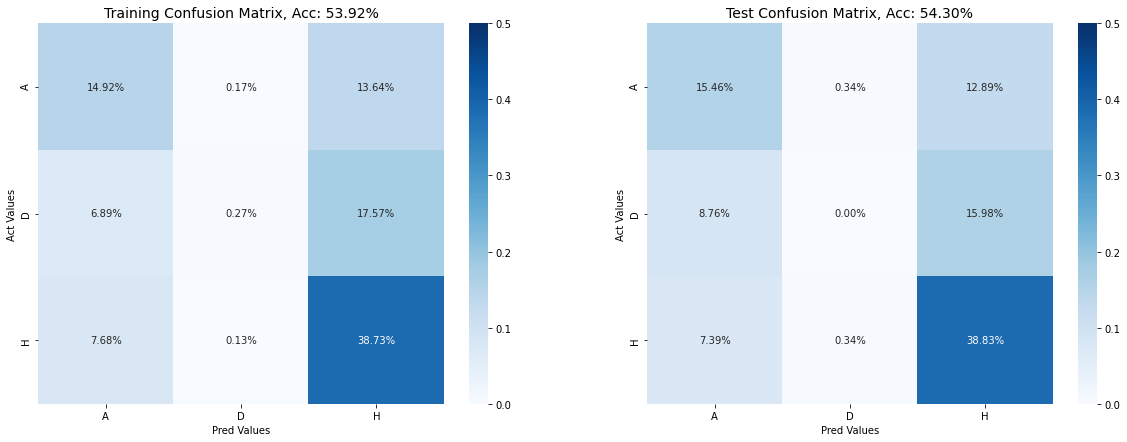

In [196]:
print_conf_mat(sm_model, y_test, x_test)

### 4d. Sklearn Logistic Regression Model

In [180]:
# define model class and train it
model = LogisticRegression(multi_class='multinomial', solver = 'lbfgs')
model.fit(x_train, y_train)

LogisticRegression(multi_class='multinomial')

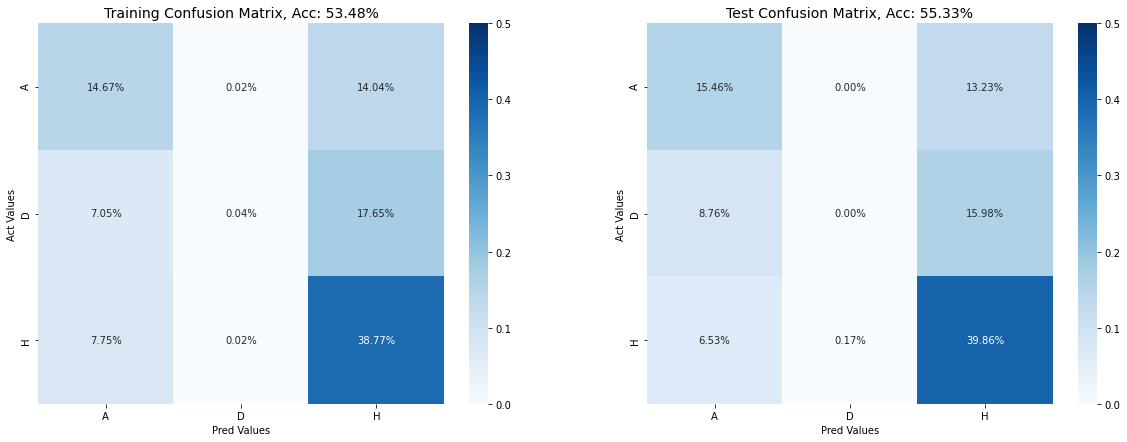

In [181]:
print_conf_mat(model, y_test, x_test, lib='sklearn', x_train=x_train, y_train=y_train)

In [51]:
model.intercept_

array([-0.00829674, -0.01092776,  0.0192245 ])

In [52]:
model.coef_

array([[ 8.09560110e-02, -6.91728379e-03,  8.65792786e-03,
        -4.01198987e-02,  7.16422049e-03,  1.02863393e-02,
         1.62695950e-02, -1.68129853e-02, -6.51438468e-02,
         3.16163257e-02,  4.74601167e-03, -9.55915444e-03,
         2.71130363e-02, -5.82962747e-02, -8.70482463e-03,
        -1.13795554e-03,  3.56122328e-03, -3.86986516e-03,
         7.82931545e-03, -1.19661910e-02, -1.22660479e-02,
        -2.73190962e-03, -1.97955064e-02],
       [-7.96077711e-02,  6.29919311e-02,  5.00414976e-02,
         3.41371139e-02, -2.52218282e-02, -2.15688025e-02,
        -3.23545391e-03,  2.58491142e-03,  4.13504825e-02,
         1.66036228e-02, -9.27826261e-03, -2.30329690e-02,
         6.06482036e-02, -2.52403616e-03,  2.22824885e-03,
         5.07175001e-03, -1.58563043e-03, -3.96755331e-04,
         2.33442605e-03,  2.41542655e-03,  3.81387928e-03,
        -5.46850534e-03,  8.10005001e-05],
       [-1.34823985e-03, -5.60746473e-02, -5.86994255e-02,
         5.98278476e-03,  1.8

In [53]:
[x - model.intercept_[0] for x in model.intercept_]

[0.0, -0.002631014680963722, 0.027521247801644215]

In [54]:
[x - model.coef_[0] for x in model.coef_]

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.]),
 array([-0.16056378,  0.06990921,  0.04138357,  0.07425701, -0.03238605,
        -0.03185514, -0.01950505,  0.0193979 ,  0.10649433, -0.0150127 ,
        -0.01402427, -0.01347381,  0.03353517,  0.05577224,  0.01093307,
         0.00620971, -0.00514685,  0.00347311, -0.00549489,  0.01438162,
         0.01607993, -0.0027366 ,  0.01987651]),
 array([-0.08230425, -0.04915736, -0.06735735,  0.04610268,  0.01089339,
         0.00099612, -0.02930374,  0.03104106,  0.08893721, -0.07983627,
        -0.00021376,  0.04215128, -0.11487428,  0.11911659,  0.0151814 ,
        -0.00279584, -0.00553682,  0.00813649, -0.01799306,  0.02151696,
         0.02071822,  0.01093232,  0.03951001])]

In [433]:
sm_probs = sm_model.predict(sm.add_constant(x_train)).values
sm_preds = []
res_map = {0: 'A', 1: 'D', 2: 'H'}

for p in sm_probs:
    max_p = max(p)
    class_n = list(p).index(max_p)
    pred = res_map[class_n]
    sm_preds.append(pred)

In [346]:
sk_probs = model.predict_proba(x_test)

loss = []

for sk, s in zip(sk_probs, sm_probs):
    l = abs(np.subtract(sk, s))
    loss.append(l)

lo = [np.sum(x) for x in loss]

### 4f. Compare Predictions to Actual

In [171]:
df_post = df_est.copy()

In [175]:
df_post['Pred'] = model.predict(df_post[features].to_numpy())
df_post['Correct'] = np.where(df_post.Pred == df_post.FTR, True, False)

In [182]:
df_preds = pd.DataFrame(data=model.predict_proba(df_post[features].to_numpy()), columns=[x+'_PredProb' for x in model.classes_])
df_preds = df_preds[df_preds.columns[::-1]]
df_preds['PredH'] = 1 / df_preds['H_PredProb']
df_preds['PredD'] = 1 / df_preds['D_PredProb']
df_preds['PredA'] = 1 / df_preds['A_PredProb']

In [195]:
df_post = pd.concat([df_post.reset_index(drop=True), df_preds], axis=1)

<AxesSubplot:xlabel='AwayLeagPos', ylabel='HomeLeagPos'>

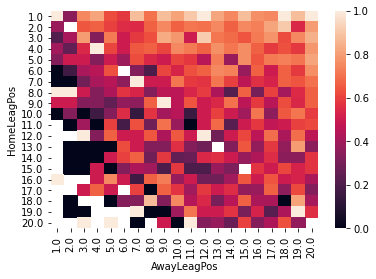

In [221]:
#[[x for x in df_post.columns if x not in features]]
sns.heatmap(pd.pivot_table(df_post[(df_post.Div == 'E0') & (df_post.Pred == 'H')][['HomeLeagPos', 'AwayLeagPos', 'Correct']], columns='AwayLeagPos', index='HomeLeagPos', values='Correct'))

Tests to run:
 - Use hue on cat to compare scatters vs features
 - Ability to spit out factor sensitivities and analyse for logistic reg

Improvements:
 - Potentially normalise data
 - Potentially resample data to equalise frequency of W/L/D
 - Thoughts on augmenting loss function to include benefit for predicting unlikely events - determined by historical odds